In [1]:
import os
import sys
import time
import glob
import numpy as np
import pandas as pd
import scipy.ndimage as nd
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf
from numpy import genfromtxt
from scipy import stats
from scipy import ndimage
from sklearn import linear_model
from sklearn.cluster import KMeans
from ph_scan import *

In [2]:
# -- initialize seed
np.random.seed(234)

In [3]:
fname = 'Delivery/057773250010_01/057773250010_01_P002_MUL/17SEP18165731-M2AS-057773250010_01_P002.TIF'
scan = PhScan(fname)

reading Delivery/057773250010_01/057773250010_01_P002_MUL/17SEP18165731-M2AS-057773250010_01_P002.TIF...
extracting to array...  (extracted in 2.02604484558s)
rescaling...


In [4]:
img0 = scan.img.transpose(1, 2, 0)
img0.shape

(6703, 4220, 4)

In [5]:
# only include pixels have ndvi larger than 0.3
ndvi = scan.ndvi
mask = ndvi <= 0.3
mask = mask * 1

In [6]:
b = np.repeat(mask[:, :, np.newaxis], 4, axis=2)

In [7]:
# 4 features to cluster
# array_masked = np.ma.array(img0, mask=b, fill_value=0)
# 100 features to cluster
array_masked = np.ma.array(img0, mask=b, fill_value=None)
img = array_masked.filled()
img.shape

(6703, 4220, 4)

In [8]:
# -- put this into a shape for clustering
nrow = img.shape[0]
ncol = img.shape[1]
nwav = img.shape[2]
npix = nrow * ncol

In [9]:
# # using four features(4 color band) to cluster
# data = img.transpose(2, 0, 1).reshape(nwav, nrow * ncol).T
# # -- cluster a 5% subset
# km = KMeans(5, n_jobs=10)
# norm = data - data.mean(1, keepdims=True)
# norm /= norm.std(1, keepdims=True) + (norm.std(1, keepdims=True) == 0)

# ind_nz = np.where(norm.any(axis=1))[0]
# ind = np.random.choice(ind_nz, int(0.05 * npix))
# km.fit(norm[ind])

In [10]:
# using 100 features (5*5 window of pixels) to cluster
data = np.ones((nrow, ncol, nwav * 25), dtype=img.dtype) * 16959
for ii in range(2, nrow - 3):
    for jj in range(2, ncol - 3):
        data[ii, jj] = img[ii - 2: ii + 3, jj - 2: jj + 3] \
            .transpose(2, 0, 1).flatten()
data = data.transpose(2, 0, 1).reshape(data.shape[2], npix).T
i, j = np.where(data == 16959)
i = np.unique(i)
index = np.arange(data.shape[0], dtype=i.dtype)
mask_id = np.ones(len(data), dtype=bool)
mask_id[i] = False
result = index[mask_id]
km = KMeans(5, n_jobs=10)
norm = data - data.mean(1, keepdims=True)
norm /= norm.std(1, keepdims=True) + (norm.std(1, keepdims=True) == 0)
ind_nz = result
ind = np.random.choice(ind_nz, int(0.05 * npix))
km.fit(norm[ind])

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=5, n_init=10, n_jobs=10, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

In [11]:
labs = np.ones((npix), dtype=float) * 20

In [12]:
# -- predict on whole data set
labs[ind_nz] = km.predict(norm[ind_nz])
labs_img = labs.reshape(nrow, ncol)

In [13]:
# cluster number from 1-5, masked pixel number 0
labs_img = labs_img + 1
labs_img[labs_img == 21] = 0

<function matplotlib.pyplot.show>

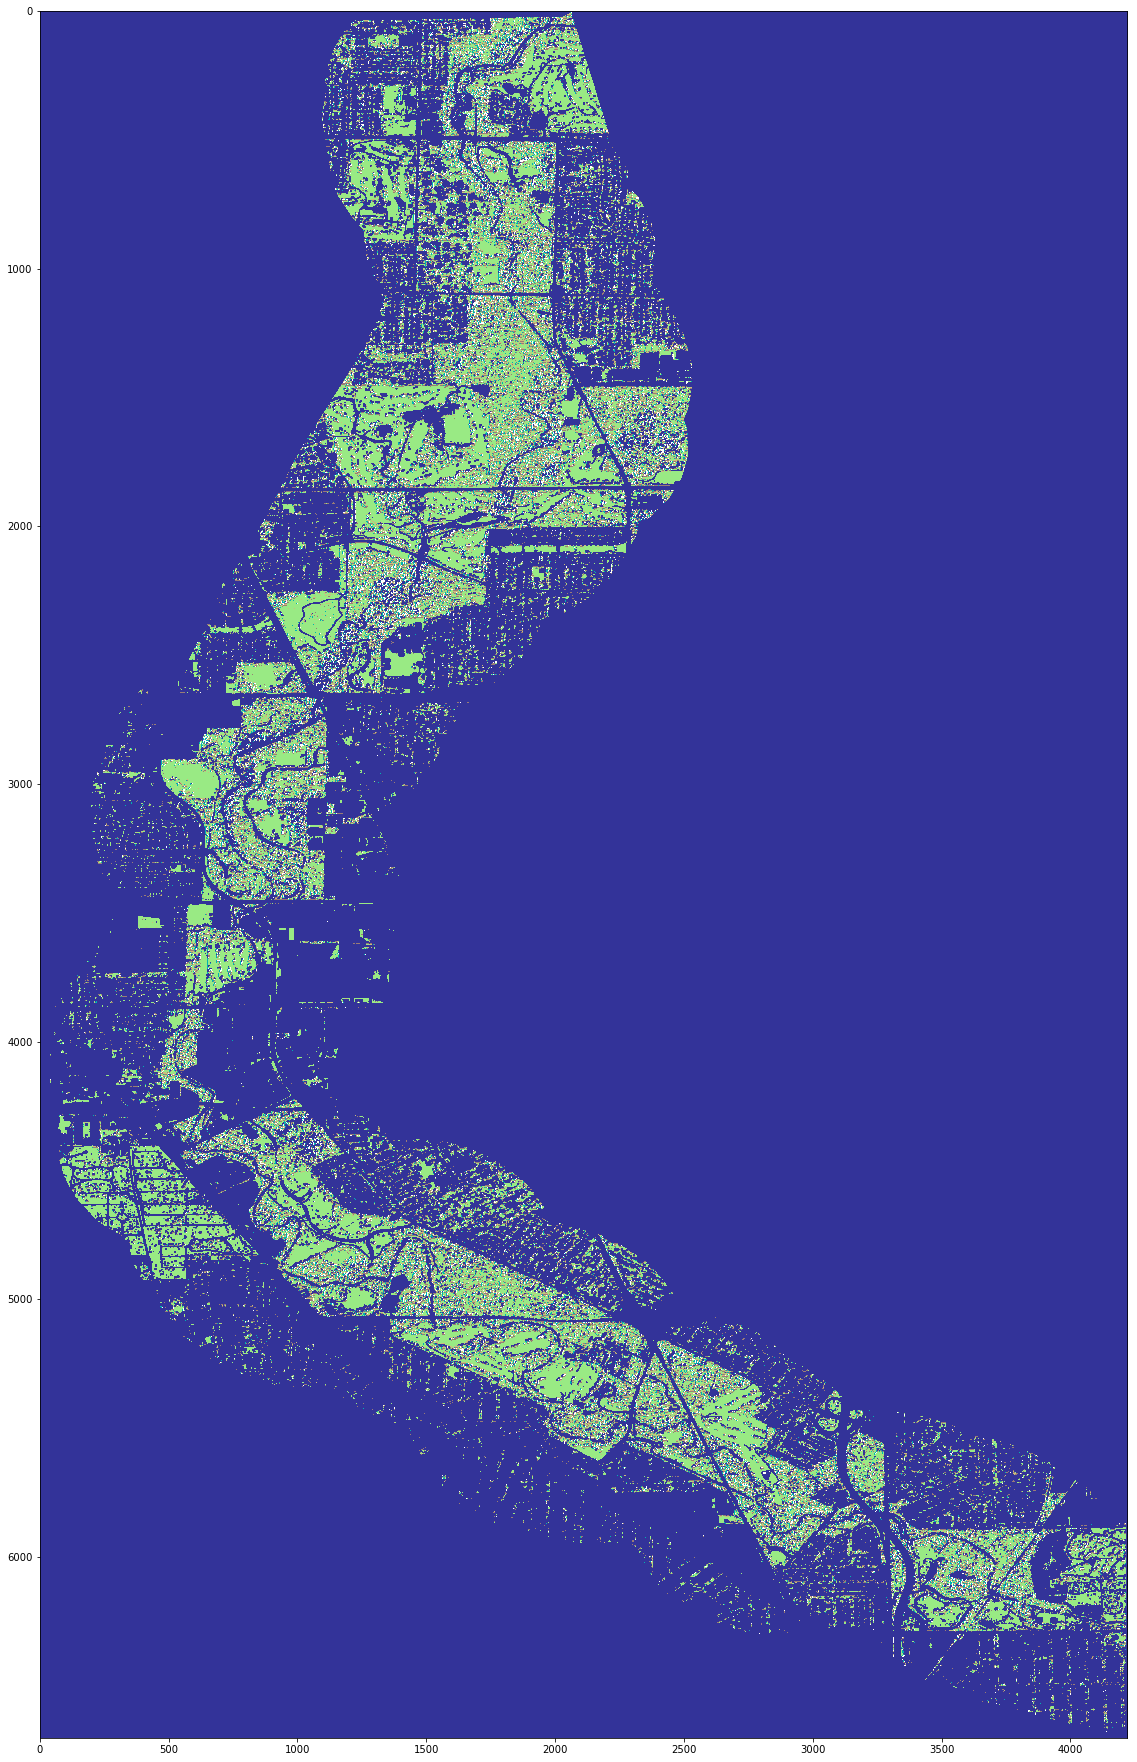

In [14]:
xsize = 20.
ysize = xsize * float(nrow) / float(ncol)
plt.figure(figsize=[xsize, ysize])
fn = fname.split(".")[0]
fn = fn.replace('/', '.')
plt.imshow(labs_img, cmap='terrain')
plt.show
# plt.savefig("cluster_ndvi_0.3/"+fn+".png")